<a href="https://colab.research.google.com/github/SaketramDurbha/One-Word-Story/blob/master/Problem_Two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Two

## Dropout during training vs test time

Obviously dropout — at least under our implementation — only takes effect during train time. No nodes zeroed out during test time.

However, if we just dropped nodes during train time without scaling them approrpriately, we would find — as the dropout paper says — the "expected outuput" of a given node during train and test time would be different.

Mathematically:

Say the "expected ouptut" of a node without any dropout is "z". Then of course its expected output during test time is also z because we don't zero any nodes during test time.

However, during train time — with dropout and without any scaling — its expected output becomes:

0 * (dropout_rate) + z * (1 - dropout_rate)

which is obviously different than its expected output during test time.

This is why we scale the node's output by (1 - dropout_rate) during train time so its expected output is normalized:

0 * (dropout_rate) + (z / (1 - dropout_rate)) * (1 - dropout_rate)
= z

as expected.

This helps ensure that layers downstream of the dropout layer learn weights properly. If the expected outputs of dropout nodes were different between train and test time, then the weights learned during train time would be wrong come test time.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [2]:
import matplotlib.pyplot as plt
import torch

from q2_cifar10 import main

In [3]:
torch.cuda.is_available()

True

In [4]:
WEIGHT_DECAYS = [1e-2, 1e-3, 1e-4]

In [ ]:
tr_loss_trajectories = []
tr_acc_trajectories = []
te_loss_trajectories = []
te_acc_trajectories = []

for weight_decay in WEIGHT_DECAYS:
    print(f"training with weight decay: {weight_decay}")
    tr_loss_trajectory, tr_acc_trajectory, te_loss_trajectory, te_acc_trajectory = main(weight_decay=weight_decay, dropout_rate=0)

    tr_loss_trajectories.append(tr_loss_trajectory)
    tr_acc_trajectories.append(tr_acc_trajectory)
    te_loss_trajectories.append(te_loss_trajectory)
    te_acc_trajectories.append(te_acc_trajectory)

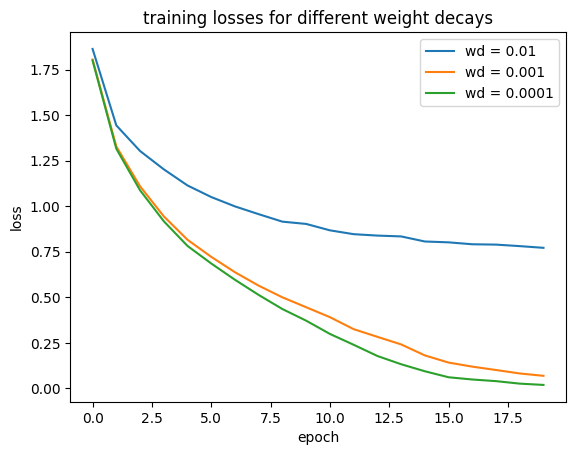

In [6]:
for wd, tr_loss_trajectory in zip(WEIGHT_DECAYS, tr_loss_trajectories):
    plt.plot(tr_loss_trajectory, label=f"wd = {wd}")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("training losses for different weight decays")
plt.show()

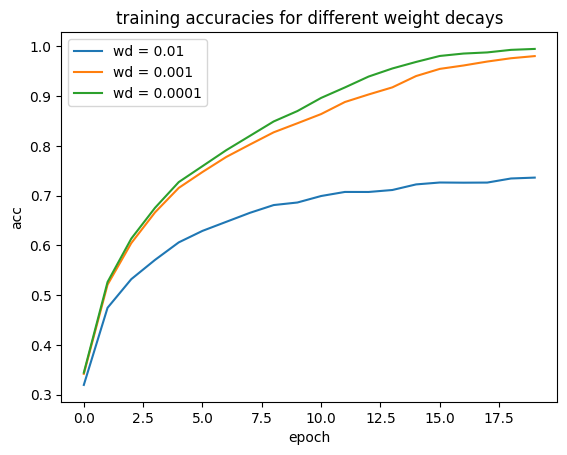

In [7]:
for wd, tr_acc_trajectory in zip(WEIGHT_DECAYS, tr_acc_trajectories):
    plt.plot(tr_acc_trajectory, label=f"wd = {wd}")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title("training accuracies for different weight decays")
plt.show()

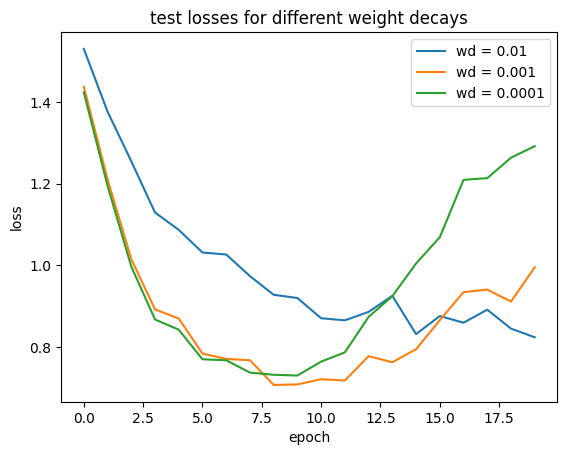

In [8]:
for wd, te_loss_trajectory in zip(WEIGHT_DECAYS, te_loss_trajectories):
    plt.plot(te_loss_trajectory, label=f"wd = {wd}")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("test losses for different weight decays")
plt.show()

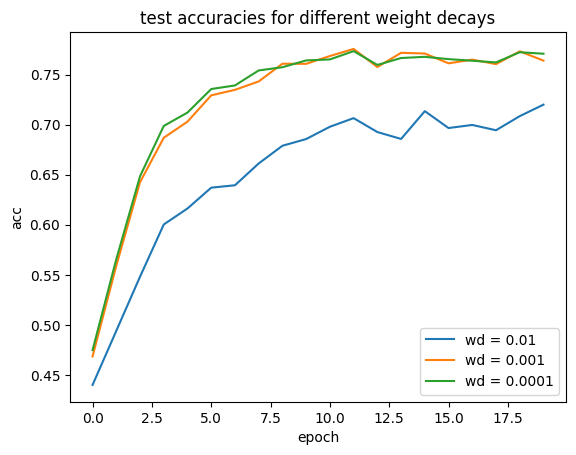

In [9]:
for wd, te_acc_trajectory in zip(WEIGHT_DECAYS, te_acc_trajectories):
    plt.plot(te_acc_trajectory, label=f"wd = {wd}")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title("test accuracies for different weight decays")
plt.show()

## Observations

Test accuracies — which I suppose are the most important metric here — were markedly worse with the highest weight decay as compared to the two smaller values.

Reading online, the purpose of weight decays seems to be to make sure that models don't overfit to samples by encouraging its weights to be smaller through the loss function or optimizer.

My guess is that this is only helpful when (A) the way your optimization problem can lead to excessively large weights like we saw in the SVM problem or (B) if the approximation error of your hypothesis class is so low so as to make overfitting a serious concern.

It may be that neither of these concerns apply in our case. The XxY distribution here could be simple enough here that overfitting isn't possible with our model. And I'm also not sure that we care too much about our weights getting too large or small especially after our normalization step.

The test loss curves are interesting, especially as they seem to start going back up as their respective accuracy curves stayed constant and high. More surprising is the fact that that effect is more pronounced with smaller weight decays. I'm not sure why this is the case.

Sources:
*   https://arxiv.org/pdf/2310.04415
*   https://stats.stackexchange.com/questions/29130/difference-between-neural-net-weight-decay-and-learning-rate

In [ ]:
DROPOUT_RATES = [0, 0.2, 0.5, 0.8]

do_tr_loss_trajectories = []
do_tr_acc_trajectories = []
do_te_loss_trajectories = []
do_te_acc_trajectories = []

for dropout_rate in DROPOUT_RATES:
    print(f"training with dropout rate: {dropout_rate}")
    tr_loss_trajectory, tr_acc_trajectory, te_loss_trajectory, te_acc_trajectory = main(weight_decay=0, dropout_rate=dropout_rate)

    do_tr_loss_trajectories.append(tr_loss_trajectory)
    do_tr_acc_trajectories.append(tr_acc_trajectory)
    do_te_loss_trajectories.append(te_loss_trajectory)
    do_te_acc_trajectories.append(te_acc_trajectory)

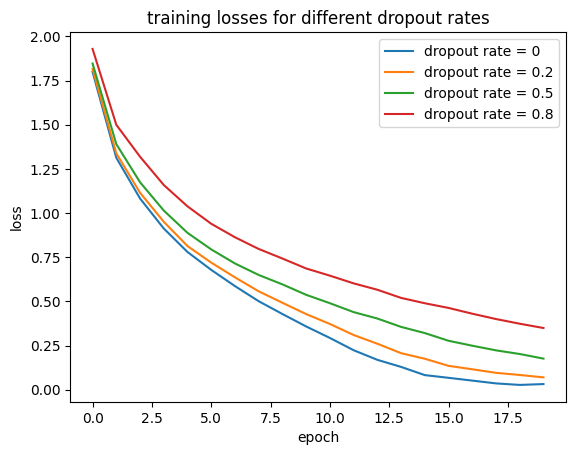

In [12]:
for dropout_rate, tr_loss_trajectory in zip(DROPOUT_RATES, do_tr_loss_trajectories):
    plt.plot(tr_loss_trajectory, label=f"dropout rate = {dropout_rate}")


plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("training losses for different dropout rates")
plt.show()

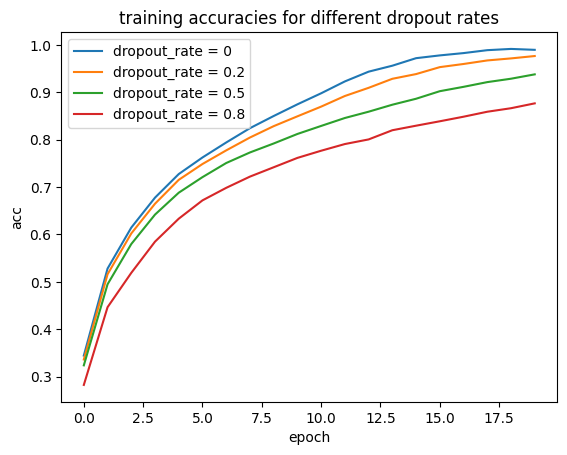

In [13]:
for dropout_rate, tr_acc_trajectory in zip(DROPOUT_RATES, do_tr_acc_trajectories):
    plt.plot(tr_acc_trajectory, label=f"dropout_rate = {dropout_rate}")


plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title("training accuracies for different dropout rates")
plt.show()

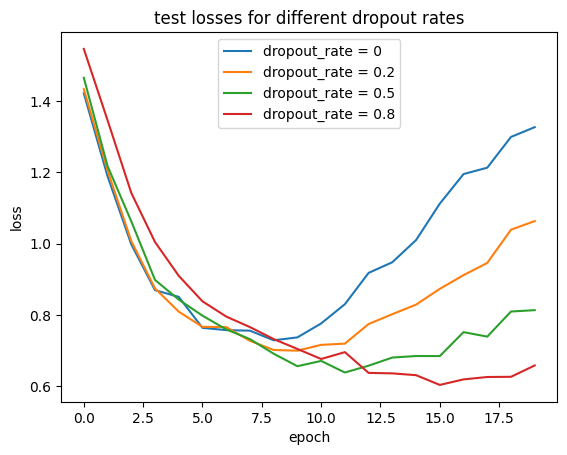

In [14]:
for dropout_rate, te_loss_trajectory in zip(DROPOUT_RATES, do_te_loss_trajectories):
    plt.plot(te_loss_trajectory, label=f"dropout_rate = {dropout_rate}")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("test losses for different dropout rates")
plt.show()

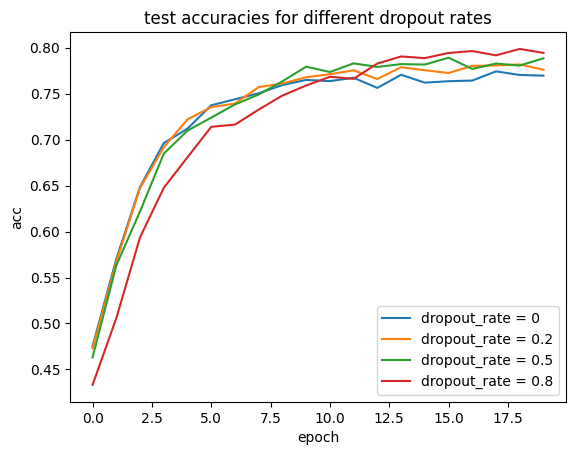

In [15]:
for dropout_rate, te_acc_trajectory in zip(DROPOUT_RATES, do_te_acc_trajectories):
    plt.plot(te_acc_trajectory, label=f"dropout_rate = {dropout_rate}")


plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title("test accuracies for different dropout rates")
plt.show()

## Observations

Looking at test accuracies again — higher dropout rates seemed to perform better than lower ones.

This makes sense given that, based on the dropout paper, the method is also another method to prevent overfitting in models. This time by encouraging nodes from not "co-adapting"" too much and hence making the model more robust in theory. It seems like that model is working here.

The test losses curves also make more sense here. It could be that even though the model is being updated with the gradients of the loss function based on dropped out nodes during train time, this converts to a strong performing model during test time even if the loss function doesn't reflect that.